# Flax-Pilot Classifer MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a Classifier. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [ ]:
!pip install -q tensorflow-cpu

In [2]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [3]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a simple Classifier Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [32]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, deterministic):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  
    x = nn.Dense(features=256)(x)
    x = nn.Dropout(rate=0.3, deterministic=deterministic)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x


### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [33]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7deff6fd25f0>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7deff6fd09a0>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these five specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global key received here can be splitted into multliple keys using `jax.random.split`. These splits can be represented as a dict where keys are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the key itself.
     - From within the model, keys can be accessed by `self.make_rng(rng_name)`.


### Note:
- All these five parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [34]:
def loss_fn(params, apply, sample, deterministic, global_key):
    x, y = sample
    yp = apply(params, x, deterministic=deterministic, rngs={'dropout': global_key})
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp)}
    }
    return loss, loss_metric_values_dict


In [35]:
import glob, sys
sys.path.append("/kaggle/input/flax-trainer/")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [37]:
import trackers as tr

trackers = {
        'lt': {'loss': tr.Mean()},
        'mt':{'f1': tr.F1Score(threshold=0.7), 'acc': tr.Accuracy(threshold=0.7)}
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: An `optax` optimizer.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [38]:
from trainer import Trainer
trainer = Trainer(CNN(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [39]:
trainer.train(20, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/models/class', 1)

Epoch 1: 100%|██████████| 234/234 [00:02<00:00, 87.47it/s] 


Train:  loss: 0.27308935, acc: 0.98195285, f1: 0.9016377, time: 2.6782822608947754
Val:  loss: 0.07594742, acc: 0.9945613, f1: 0.9720359, time: 0.7997894287109375


Epoch 2: 100%|██████████| 234/234 [00:00<00:00, 450.27it/s]


Train:  loss: 0.0773122, acc: 0.9946765, f1: 0.9727349, time: 0.5227766036987305
Val:  loss: 0.04545197, acc: 0.9964744, f1: 0.98211336, time: 0.07857775688171387


Epoch 3: 100%|██████████| 234/234 [00:00<00:00, 419.10it/s]


Train:  loss: 0.056341663, acc: 0.9961405, f1: 0.9803399, time: 0.5619571208953857
Val:  loss: 0.036429048, acc: 0.9971956, f1: 0.9857706, time: 0.07155704498291016


Epoch 4: 100%|██████████| 234/234 [00:00<00:00, 440.88it/s]


Train:  loss: 0.044145644, acc: 0.9969084, f1: 0.984313, time: 0.5340797901153564
Val:  loss: 0.035028253, acc: 0.99743587, f1: 0.98695666, time: 0.07113337516784668


Epoch 5: 100%|██████████| 234/234 [00:00<00:00, 449.59it/s]


Train:  loss: 0.035100333, acc: 0.9975211, f1: 0.9874698, time: 0.5231425762176514
Val:  loss: 0.033297937, acc: 0.9975561, f1: 0.98756874, time: 0.07079219818115234


Epoch 6: 100%|██████████| 234/234 [00:00<00:00, 414.58it/s]


Train:  loss: 0.029688712, acc: 0.99797344, f1: 0.9897474, time: 0.5674593448638916
Val:  loss: 0.032324154, acc: 0.99773645, f1: 0.9885138, time: 0.07995748519897461


Epoch 7: 100%|██████████| 234/234 [00:00<00:00, 441.27it/s]


Train:  loss: 0.026450556, acc: 0.99807525, f1: 0.99027073, time: 0.5352239608764648
Val:  loss: 0.029139405, acc: 0.99788666, f1: 0.98927695, time: 0.0687103271484375


Epoch 8: 100%|██████████| 234/234 [00:00<00:00, 442.71it/s]


Train:  loss: 0.02307437, acc: 0.99832404, f1: 0.99154454, time: 0.531550407409668
Val:  loss: 0.02905555, acc: 0.9978466, f1: 0.9890411, time: 0.07589292526245117


Epoch 9: 100%|██████████| 234/234 [00:00<00:00, 422.02it/s]


Train:  loss: 0.020737551, acc: 0.9984509, f1: 0.99216115, time: 0.5593423843383789
Val:  loss: 0.029403701, acc: 0.9979768, f1: 0.9897437, time: 0.0731363296508789


Epoch 10: 100%|██████████| 234/234 [00:00<00:00, 443.64it/s]


Train:  loss: 0.016770944, acc: 0.99878323, f1: 0.99388444, time: 0.5304222106933594
Val:  loss: 0.0313595, acc: 0.9978566, f1: 0.9890747, time: 0.07250714302062988


Epoch 11: 100%|██████████| 234/234 [00:00<00:00, 362.68it/s]


Train:  loss: 0.01638691, acc: 0.9988133, f1: 0.9940076, time: 0.6481173038482666
Val:  loss: 0.031280007, acc: 0.9979968, f1: 0.98983276, time: 0.08608818054199219


Epoch 12: 100%|██████████| 234/234 [00:00<00:00, 357.12it/s]


Train:  loss: 0.014452007, acc: 0.99894506, f1: 0.9946835, time: 0.6592304706573486
Val:  loss: 0.029298183, acc: 0.9980469, f1: 0.9901314, time: 0.0881955623626709


Epoch 13: 100%|██████████| 234/234 [00:00<00:00, 430.57it/s]


Train:  loss: 0.014147395, acc: 0.9989452, f1: 0.9946801, time: 0.5466477870941162
Val:  loss: 0.033284362, acc: 0.9979868, f1: 0.98978937, time: 0.07239103317260742


Epoch 14: 100%|██████████| 234/234 [00:00<00:00, 393.85it/s]


Train:  loss: 0.012679859, acc: 0.99904364, f1: 0.9951877, time: 0.5973949432373047
Val:  loss: 0.03834232, acc: 0.99776644, f1: 0.988724, time: 0.08805346488952637


Epoch 15: 100%|██████████| 234/234 [00:00<00:00, 426.71it/s]


Train:  loss: 0.011403386, acc: 0.99912876, f1: 0.99561745, time: 0.5520296096801758
Val:  loss: 0.032540545, acc: 0.9980169, f1: 0.9899496, time: 0.07247376441955566


Epoch 16: 100%|██████████| 234/234 [00:00<00:00, 426.81it/s]


Train:  loss: 0.010193065, acc: 0.99923223, f1: 0.9961423, time: 0.5520312786102295
Val:  loss: 0.03202471, acc: 0.9979968, f1: 0.9898725, time: 0.07317543029785156


Epoch 17: 100%|██████████| 234/234 [00:00<00:00, 431.76it/s]


Train:  loss: 0.0093308, acc: 0.9992973, f1: 0.99646914, time: 0.5450589656829834
Val:  loss: 0.03720181, acc: 0.9979167, f1: 0.98948777, time: 0.07834482192993164


Epoch 18: 100%|██████████| 234/234 [00:00<00:00, 430.11it/s]


Train:  loss: 0.008442412, acc: 0.9993491, f1: 0.9967307, time: 0.5474424362182617
Val:  loss: 0.030165244, acc: 0.9982272, f1: 0.99101484, time: 0.072784423828125


Epoch 19: 100%|██████████| 234/234 [00:00<00:00, 444.89it/s]


Train:  loss: 0.008402882, acc: 0.999324, f1: 0.9966067, time: 0.5292453765869141
Val:  loss: 0.03711932, acc: 0.9978967, f1: 0.9893865, time: 0.06876873970031738


Epoch 20: 100%|██████████| 234/234 [00:00<00:00, 432.61it/s]


Train:  loss: 0.008296672, acc: 0.9993291, f1: 0.9966341, time: 0.5439581871032715
Val:  loss: 0.02993455, acc: 0.99816704, f1: 0.99070203, time: 0.07585453987121582


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [67]:
sample = next(val_ds)
x, y = sample[0][:, :8], sample[1][:, :8]

rngs = {} # no rng needed bcz prediction doesnt require dropout
tensor_inputs = {'x': x}

yp = trainer(rngs, tensor_inputs, deterministic=True)
yp = nn.softmax(yp, axis=-1).argmax(axis=-1)


# pred with dropout
# sample = next(val_ds)
# x, y = sample[0][:, :8], sample[1][:, :8]

# rngs = {'dropout': jax.random.PRNGKey(43)} 
# tensor_inputs = {'x': x}

# yp = trainer(rngs, tensor_inputs, deterministic=False)

### Evaluate the model

In [64]:
trainer.evaluate(val_ds, 10000//256)

Val:  loss: 0.02941408, acc: 0.99816704, f1: 0.9907019, time: 0.0757300853729248


### Compute trackers

In [46]:
trainer.compute_trackers()

{'lt': {'loss': Array([0.03256229, 0.02801017], dtype=float32)},
 'mt': {'acc': Array([0.9979367, 0.9983773], dtype=float32),
  'f1': Array([0.98951465, 0.99180424], dtype=float32)}}

### Save & Load checkpoints

In [47]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/models/class')

State saved..


In [48]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/models/class', 4680)

### Visualize results

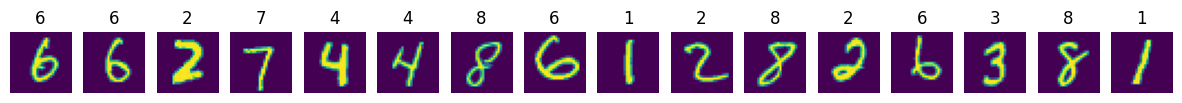

In [71]:
import matplotlib.pyplot as plt

yp = yp.reshape(16, -1)
x = x.reshape(16, 28, 28, 1)

plot_images = iter(x)
labels = iter(yp)
fig, ax = plt.subplots(1, 16, figsize=(15, 15))

for i in range(16):
        ax[i].imshow(next(plot_images))
        ax[i].set_title(str(next(labels)[0]))
        ax[i].axis('off')